In [8]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [171]:
'''
Returns the sum of 2 vectors of not necesseraly the same length by appending 0's to the shorter vector.
'''
def sum_two_vec_pad(a, b):
    if len(a) < len(b):
        c = b.copy()
        c[:len(a)] += a
    else:
        c = a.copy()
        c[:len(b)] += b
    return c

'''
returns the energy for an estimated weight vector omega, with data (X, Y)
'''
def energy(w, X, Y):
    Y_est = np.sign(np.dot(X, w))
    return 0.5 * np.sum((Y - Y_est)**2)

def accept_prob(wp, w, beta, X, Y):
    return min(1, np.exp(-beta*(energy(wp, X, Y) - energy(w, X, Y))))

def accept_prob_with_energy(wp, w, beta, X, Y):
    next_energy = energy(wp, X, Y)
    return (min(1, np.exp(-beta*(next_energy - energy(w, X, Y)))), next_energy)

def accept_prob_with_energy_using_energy(wp, prev_energy, beta, X, Y):
    next_energy = energy(wp, X, Y)
    return (min(1.0, np.exp(-beta*(next_energy - prev_energy))), next_energy)

def overlap(wp, w):
    return 1.0 / (w.shape[0]) * np.dot(w, wp)

In [10]:
def delta_energy_fast(w, wp, idx, X, Y):
    Xw = np.dot(X, w)
    w_tmp = np.zeros(w.shape[0])
    w_tmp[idx] = wp[idx] - w[idx] 
    Xwp = Xw + np.dot(X, w_tmp)
    Y_est = np.sign(Xw)
    Y_estp = np.sign(Xwp)
    return 0.5 * np.sum((Y - Y_estp)**2),  0.5*np.sum((Y - Y_est)**2)


def accept_prob_fast(wp, w, beta, X, Y, idx):
    e_next, e = delta_energy_fast(w, wp, idx, X, Y)
    return min(1, np.exp(-beta*(e_next - e))), e_next

In [132]:
np.random.seed(2121)

In [12]:
2*np.random.randint(0, 2, 6) -1

array([-1, -1, -1,  1, -1,  1])

In [13]:
2*np.random.randint(0, 2, 6) -1

array([-1,  1,  1, -1, -1,  1])

In [14]:
2*np.random.randint(0, 2, 6) -1

array([-1, -1,  1, -1, -1, -1])

In [15]:
def metropolis(w_init, beta, X, Y, epsilon=0):

    N = w_init.shape[0]
    w = np.copy(w_init)
    wp = np.copy(w)

    energy_record = np.array([])
    energy_record = np.append(energy_record, energy(w_init, X, Y))

    while (energy(w, X, Y) > epsilon):

        index_rand = np.random.randint(0, N)
        wp = np.copy(w)
        wp[index_rand] = -1 * wp[index_rand]

        if np.random.uniform() < accept_prob(wp, w, beta, X, Y):
            w = np.copy(wp)

        energy_record= np.append(energy_record, energy(w, X, Y))

    return w, energy_record

In [16]:
# Multiple runs of the metropolis algorithm
def metropolis_mult(nb_runs, beta, X, Y, epsilon=0):
    N = X.shape[1]
    # why of size N
    # Because we want to see the avg energy as in every dimension
    energy_record_acc = np.zeros(N)

    for k in range(0, nb_runs):
        w_init =  2 * np.random.randint(0, 2, N) - 1
        _, energy_record = metropolis(w_init, beta, X, Y, epsilon)
        #print(energy_record, " at run ", k)
        energy_record_acc = sum_two_vec_pad(energy_record_acc, energy_record)


    return energy_record_acc / nb_runs

In [17]:
###

### Part 1

###


################ 1.


def metropolis_fast(w_init, beta, X, Y, epsilon=0):

    N = w_init.shape[0]
    w = np.copy(w_init)

    energy_record = np.array([])
    current_energy = energy(w, X, Y)
    energy_record = np.append(energy_record, current_energy)

    while (current_energy > epsilon):

        index_rand = np.random.randint(0, N)
        wp = np.copy(w)
        wp[index_rand] = -1 * wp[index_rand]

        if np.random.uniform() < accept_prob(wp, w, beta, X, Y):
            # accept the move, update the weights and the current energy
            # TODO: we can also optimize this as accept prob inherently computes this energy
            w = wp 
            current_energy = energy(w, X, Y)
        
        energy_record= np.append(energy_record, current_energy)

    return w, energy_record

def metropolis_mult_fast(nb_runs, beta, X, Y, epsilon=0):
    N = X.shape[1]
    # why of size N
    energy_record_acc = np.zeros(N)

    for k in range(0, nb_runs):
        w_init =  2 * np.random.randint(0, 2, N) - 1
        _, energy_record = metropolis_fast(w_init, beta, X, Y, epsilon)
        #print(energy_record, " at run ", k)
        energy_record_acc = sum_two_vec_pad(energy_record_acc, energy_record)


    return energy_record_acc / nb_runs

In [18]:
def metropolis_fast1(w_init, beta, X, Y, epsilon=0):

    N = w_init.shape[0]
    w = np.copy(w_init)

    energy_record = np.array([])
    current_energy = energy(w, X, Y)
    energy_record = np.append(energy_record, current_energy)

    while (current_energy > epsilon):

        index_rand = np.random.randint(0, N)
        wp = np.copy(w)
        wp[index_rand] = -1 * wp[index_rand]
        
        accept_probability, next_energy = accept_prob_with_energy(wp, w, beta, X, Y)
        if np.random.uniform() < accept_probability:
            # accept the move, update the weights and the current energy
            # TODO: we can also optimize this as accept prob inherently computes this energy
            w = wp 
            current_energy = next_energy
        
        energy_record= np.append(energy_record, current_energy)

    return w, energy_record

def metropolis_mult_fast1(nb_runs, beta, X, Y, epsilon=0):
    N = X.shape[1]
    # why of size N
    energy_record_acc = np.zeros(N)

    for k in range(0, nb_runs):
        w_init =  2 * np.random.randint(0, 2, N) - 1
        _, energy_record = metropolis_fast1(w_init, beta, X, Y, epsilon)
        #print(energy_record, " at run ", k)
        energy_record_acc = sum_two_vec_pad(energy_record_acc, energy_record)


    return energy_record_acc / nb_runs

In [34]:
def metropolis_fastest(w_init, beta, X, Y, epsilon=0):

    N = w_init.shape[0]
    w = np.copy(w_init)

    energy_record = np.array([])
    current_energy = energy(w, X, Y)
    energy_record = np.append(energy_record, current_energy)
    ctr = 0
    while (current_energy > epsilon):
        ctr +=1
        index_rand = np.random.randint(0, N)
        wp = np.copy(w)
        wp[index_rand] = -1 * wp[index_rand]
        
        accept_probability, next_energy = accept_prob_with_energy_using_energy(wp, current_energy, beta, X, Y)
        if np.random.uniform() < accept_probability:
            # accept the move, update the weights and the current energy
            w = wp 
            current_energy = next_energy
        
        energy_record= np.append(energy_record, current_energy)
        
    return w, energy_record, ctr

def metropolis_mult_fastest(nb_runs, beta, X, Y, epsilon=0):
    N = X.shape[1]
    # why of size N
    energy_record_acc = np.zeros(N)

    for k in range(0, nb_runs):
        w_init =  2 * np.random.randint(0, 2, N) - 1
        _, energy_record, ctr = metropolis_fastest(w_init, beta, X, Y, epsilon)
        energy_record_acc = sum_two_vec_pad(energy_record_acc, energy_record)
        

    return energy_record_acc / nb_runs

In [20]:
def metropolis_faster(w_init, beta, X, Y, epsilon=0):

    N = w_init.shape[0]
    w = np.copy(w_init)

    energy_record = np.array([])
    current_energy = energy(w, X, Y)
    energy_record = np.append(energy_record, current_energy)
    
    while (current_energy > epsilon):

        index_rand = np.random.randint(0, N)
        wp = np.copy(w)
        wp[index_rand] = -1 * wp[index_rand]
        accept_probability, next_energy = accept_prob_fast(wp, w, beta, X, Y, index_rand)
        if np.random.uniform() < accept_probability:
            # accept the move, update the weights and the current energy
            w = wp 
            current_energy = next_energy
        
        energy_record= np.append(energy_record, current_energy)

    return w, energy_record

def metropolis_mult_faster(nb_runs, beta, X, Y, epsilon=0):
    N = X.shape[1]
    # why of size N
    energy_record_acc = np.zeros(N)

    for k in range(0, nb_runs):
        w_init =  2 * np.random.randint(0, 2, N) - 1
        _, energy_record = metropolis_faster(w_init, beta, X, Y, epsilon)
        #print(energy_record, " at run ", k)
        energy_record_acc = sum_two_vec_pad(energy_record_acc, energy_record)


    return energy_record_acc / nb_runs

In [21]:
# alpha and beta in [0.5, 5], for 'interesting' results as per paper.
N = 40
M = 200
alpha = M / N
beta = 0.2

w = 2 * np.random.random_integers(0, 1, N) - 1

# drawn randomly from normal/gaussian distribution of 0 mean & unit variance
# matrix of shape (200, 40)
X = np.random.randn(M, N)

# vector of shape (200, )
Y = np.sign(np.dot(X, w))


/mlodata1/sidak/anaconda/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: This function is deprecated. Please call randint(0, 1 + 1) instead
  import sys


In [22]:
nb_runs = 10


24.704967570956796


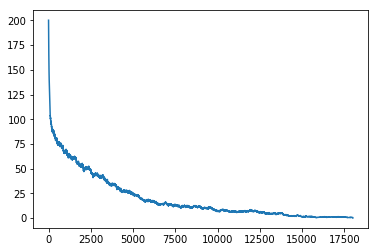

In [75]:
# Tests for part 1.
import timeit
start_time = timeit.default_timer()


part1_1 = metropolis_mult_fast(nb_runs, beta, X, Y, epsilon=0)
plt.plot(part1_1);
elapsed = timeit.default_timer() - start_time
print(elapsed)

35.081297509837896


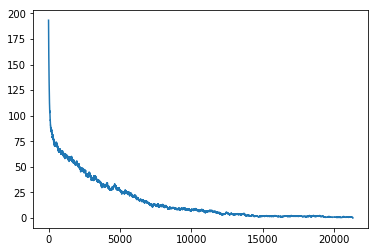

In [76]:
# Tests for part 1.
import timeit
start_time = timeit.default_timer()

part1_1 = metropolis_mult(nb_runs, beta, X, Y, epsilon=0)
plt.plot(part1_1);
elapsed = timeit.default_timer() - start_time
print(elapsed)

17.854145042132586


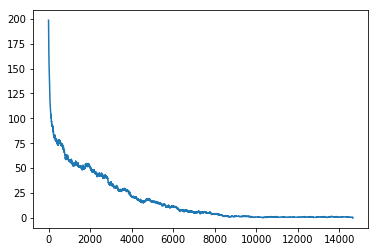

In [77]:
# Tests for part 1.
import timeit
start_time = timeit.default_timer()

part1_1 = metropolis_mult_faster(nb_runs, beta, X, Y, epsilon=0)
plt.plot(part1_1);
elapsed = timeit.default_timer() - start_time
print(elapsed)

28.527957543265074


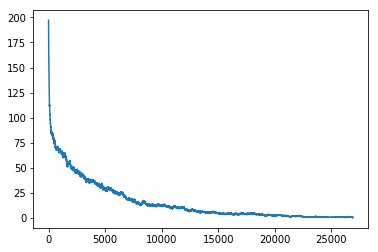

In [78]:
# Tests for part 1.
import timeit
start_time = timeit.default_timer()

part1_1 = metropolis_mult_fast1(nb_runs, beta, X, Y, epsilon=0)
plt.plot(part1_1);
elapsed = timeit.default_timer() - start_time
print(elapsed)

1.2162778479978442


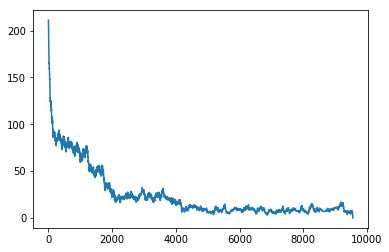

In [33]:
# Tests for part 1.
import timeit
start_time = timeit.default_timer()

part1_1 = metropolis_mult_fastest(nb_runs, beta, X, Y, epsilon=0)
plt.plot(part1_1);
elapsed = timeit.default_timer() - start_time
print(elapsed)

1.525174472015351


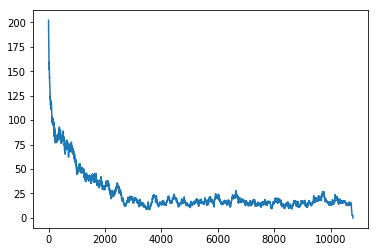

In [86]:
# Tests for part 1.
import timeit
start_time = timeit.default_timer()

part1_1 = metropolis_mult_fastest(nb_runs, beta, X, Y, epsilon=0)
plt.plot(part1_1);
elapsed = timeit.default_timer() - start_time
print(elapsed)

The reason we have to do such a sum_two_vec_pad is because in the end we want to obtain how the energy trends on average over the nb_runs. Also, it makes sense to use a 0 padding corresponding to the iterations for which we don't have values returned Metropolis. This is because the Metropolis would have converged and the energy would be 0 for those later iterations! 

Some inspection done earlier:

len of energy record at run  k : 0  is  971  and metropolis ran for ctr:  970
len of energy_record_acc is before k is  40
len of energy_record_acc is after k is  971
len of energy record at run  k : 1  is  1913  and metropolis ran for ctr:  1912
len of energy_record_acc is before k is  971
len of energy_record_acc is after k is  1913
len of energy record at run  k : 2  is  4769  and metropolis ran for ctr:  4768
len of energy_record_acc is before k is  1913
len of energy_record_acc is after k is  4769
len of energy record at run  k : 3  is  336  and metropolis ran for ctr:  335
len of energy_record_acc is before k is  4769
len of energy_record_acc is after k is  4769
len of energy record at run  k : 4  is  1376  and metropolis ran for ctr:  1375
len of energy_record_acc is before k is  4769
len of energy_record_acc is after k is  4769
len of energy record at run  k : 5  is  2436  and metropolis ran for ctr:  2435
len of energy_record_acc is before k is  4769
len of energy_record_acc is after k is  4769
len of energy record at run  k : 6  is  4352  and metropolis ran for ctr:  4351
len of energy_record_acc is before k is  4769
len of energy_record_acc is after k is  4769
len of energy record at run  k : 7  is  3649  and metropolis ran for ctr:  3648
len of energy_record_acc is before k is  4769
len of energy_record_acc is after k is  4769
len of energy record at run  k : 8  is  1965  and metropolis ran for ctr:  1964
len of energy_record_acc is before k is  4769
len of energy_record_acc is after k is  4769
len of energy record at run  k : 9  is  1996  and metropolis ran for ctr:  1995
len of energy_record_acc is before k is  4769
len of energy_record_acc is after k is  4769

In [35]:
###

### Part 1

###


################ 2.

def metropolis2(w_init, beta, X, Y, T=10):

    N = w_init.shape[0]
    M = X.shape[0]
    w = np.copy(w_init)
    wp = np.copy(w)

    for _ in range(0, T):

        index_rand = np.random.randint(0, N)
        wp = np.copy(w)
        wp[index_rand] = -1 * wp[index_rand]

        if np.random.uniform() < accept_prob(wp, w, beta, X, Y):
            w = np.copy(wp)

    energy_record = energy(w, X, Y)

    return (1.0/M) * energy_record

def metropolis_mult2(nb_runs, N, alpha_list, beta, T):

    normalized_energies_per_alpha = np.array([])

    for alpha in alpha_list:

        M = int(round(alpha * N))

        energy_record_acc = np.zeros(nb_runs)
        
        for i in range(nb_runs):

            w = 2 * np.random.random_integers(0, 1, N) - 1
            X = np.random.randn(M, N)
            Y = np.sign(np.dot(X, w))

            w_init = 2 * np.random.random_integers(0, 1, N) - 1

            energy_record_acc[i] = metropolis2(w_init, beta, X, Y, T)

        normalized_energies_per_alpha = np.append(normalized_energies_per_alpha, np.mean(energy_record_acc))

    return normalized_energies_per_alpha

/mlodata1/sidak/anaconda/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:42: DeprecationWarning: This function is deprecated. Please call randint(0, 1 + 1) instead
/mlodata1/sidak/anaconda/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:46: DeprecationWarning: This function is deprecated. Please call randint(0, 1 + 1) instead


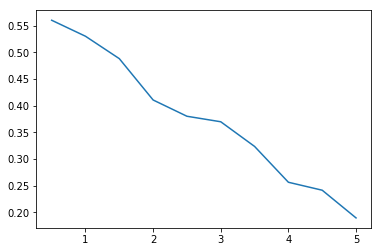

In [49]:
################

# Tests for part 2.

# alpha and beta in [0.5, 5], for 'interesting' results as per paper.
N = 40
beta = 0.4

alpha_list = np.linspace(0.5,5,10)
T = 300
nb_runs = 50
part1_2 = metropolis_mult2(nb_runs, N, alpha_list, beta, T)

plt.plot(alpha_list, part1_2);

In [50]:
###

### Part 1

###


################ 3.

def metropolis3(w_init, beta, X, Y, epsilon=0):

    N = w_init.shape[0]
    w = np.copy(w_init)
    wp = np.copy(w)

    while (energy(w, X, Y) > epsilon):

        index_rand = np.random.randint(0, N)
        wp = np.copy(w)
        wp[index_rand] = -1 * wp[index_rand]

        if np.random.uniform() < accept_prob(wp, w, beta, X, Y):
            w = np.copy(wp)

    return w

def metropolis_mult3(nb_runs, N, alpha_list, beta, epsilon=0):

    overlap_per_alpha = np.array([])

    for alpha in alpha_list:

        M = int(round(alpha * N))

        overlap_acc = np.zeros(nb_runs)
        
        for i in range(nb_runs):

            w = 2 * np.random.random_integers(0, 1, N) - 1
            X = np.random.randn(M, N)
            Y = np.sign(np.dot(X, w))

            w_init = 2 * np.random.random_integers(0, 1, N) - 1
            
            wp = metropolis3(w_init, beta, X, Y, epsilon)
            
            overlap_acc[i] = overlap(wp, w)

        overlap_per_alpha = np.append(overlap_per_alpha, np.mean(overlap_acc))

    return overlap_per_alpha

/mlodata1/sidak/anaconda/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:39: DeprecationWarning: This function is deprecated. Please call randint(0, 1 + 1) instead
/mlodata1/sidak/anaconda/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:43: DeprecationWarning: This function is deprecated. Please call randint(0, 1 + 1) instead


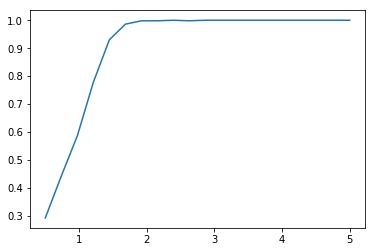

In [51]:
################

# Tests for part 3.

# alpha and beta in [0.5, 5], for 'interesting' results as per paper.
N = 20
beta = 1

alpha_list = np.linspace(0.5,5,20)
nb_runs = 50
part1_3 = metropolis_mult3(nb_runs, N, alpha_list, beta)

plt.plot(alpha_list, part1_3);

In [53]:
###

### Part 2

###


################ 1.

def metropolis4(w_init, beta_init, pace, step, is_pace, X, Y, T):

    N = w_init.shape[0]
    M = X.shape[0]
    w = np.copy(w_init)
    wp = np.copy(w)
    
    beta = beta_init
    
    for _ in range(0, T):

        index_rand = np.random.randint(0, N)
        wp = np.copy(w)
        wp[index_rand] = -1 * wp[index_rand]

        if np.random.uniform() < accept_prob(wp, w, beta, X, Y):
            w = np.copy(wp)
        
        if is_pace:
            beta *= pace
        else:
            beta += step
    
    energy_record = energy(w, X, Y)
    
    return w, (1.0/M) * energy_record


def metropolis_mult4(nb_runs, N, alpha_list, beta_init, pace, step, is_pace, T):
    
    normalized_energies_per_alpha = np.array([])
    overlap_per_alpha = np.array([])

    for alpha in alpha_list:

        M = int(round(alpha * N))

        overlap_acc = np.zeros(nb_runs)
        energy_record_acc = np.zeros(nb_runs)
        
        for i in range(nb_runs):

            w = 2 * np.random.random_integers(0, 1, N) - 1
            X = np.random.randn(M, N)
            Y = np.sign(np.dot(X, w))

            w_init = 2 * np.random.random_integers(0, 1, N) - 1
            
            wp, energy_record = metropolis4(w_init, beta_init, pace, step, is_pace, X, Y, T)
            
            energy_record_acc[i] = energy_record
            overlap_acc[i] = overlap(wp, w)

        overlap_per_alpha = np.append(overlap_per_alpha, np.mean(overlap_acc))
        normalized_energies_per_alpha = np.append(normalized_energies_per_alpha, np.mean(energy_record_acc))
        
    return normalized_energies_per_alpha, overlap_per_alpha

In [84]:
################

# Tests for part 1 and part 2

# alpha and beta in [0.5, 5], for 'interesting' results as per paper.
N = 20
beta_init = 0.35
pace = 1.002
step = 0.1
is_pace = True
alpha_list = np.linspace(0.5,5,20)
nb_runs = 50
T = 200
part2_1, part2_2 = metropolis_mult4(nb_runs, N, alpha_list, beta_init, pace, step, is_pace, T)

/mlodata1/sidak/anaconda/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:52: DeprecationWarning: This function is deprecated. Please call randint(0, 1 + 1) instead
/mlodata1/sidak/anaconda/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:56: DeprecationWarning: This function is deprecated. Please call randint(0, 1 + 1) instead


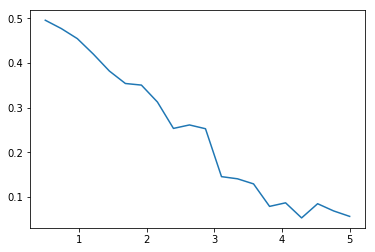

In [85]:
plt.plot(alpha_list, part2_1);

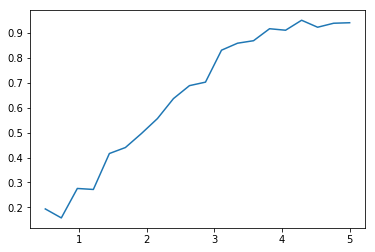

In [86]:
plt.plot(alpha_list, part2_2);

/mlodata1/sidak/anaconda/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:52: DeprecationWarning: This function is deprecated. Please call randint(0, 1 + 1) instead
/mlodata1/sidak/anaconda/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:56: DeprecationWarning: This function is deprecated. Please call randint(0, 1 + 1) instead


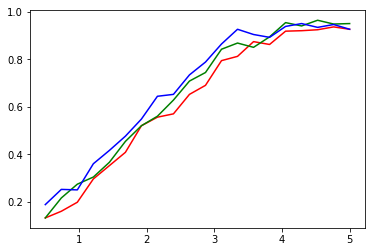

In [87]:
################

# Tests for part 1 and part 2

# alpha and beta in [0.5, 5], for 'interesting' results as per paper.
N = 20

pace = 1.002
step = 0.1
is_pace = True
alpha_list = np.linspace(0.5,5,20)
nb_runs = 50
T = 200
beta_init = 0.3
a_part2_1, a_part2_2 = metropolis_mult4(nb_runs, N, alpha_list, beta_init, pace, step, is_pace, T)
beta_init = 0.35
b_part2_1, b_part2_2 = metropolis_mult4(nb_runs, N, alpha_list, beta_init, pace, step, is_pace, T)
beta_init = 0.4
c_part2_1, c_part2_2 = metropolis_mult4(nb_runs, N, alpha_list, beta_init, pace, step, is_pace, T)


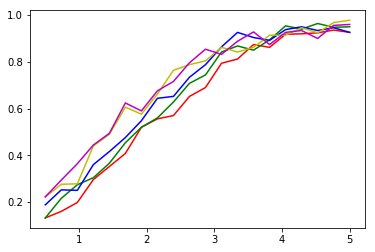

In [96]:
plt.plot(alpha_list, a_part2_2, 'r')
plt.plot(alpha_list, b_part2_2, 'g')
plt.plot(alpha_list, c_part2_2, 'b')
plt.plot(alpha_list, d_part2_2, 'y')
plt.plot(alpha_list, e_part2_2, 'm')

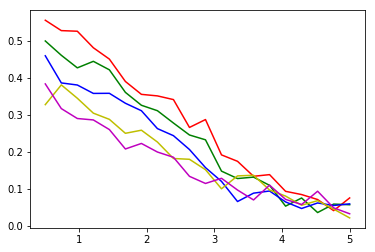

In [95]:
plt.plot(alpha_list, a_part2_1, 'r')
plt.plot(alpha_list, b_part2_1, 'g')
plt.plot(alpha_list, c_part2_1, 'b')
plt.plot(alpha_list, d_part2_1, 'y')
plt.plot(alpha_list, e_part2_1, 'm')

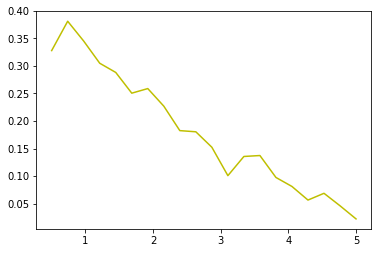

In [97]:
plt.plot(alpha_list, d_part2_1, 'y')


In [89]:
beta_init = 0.45
d_part2_1, d_part2_2 = metropolis_mult4(nb_runs, N, alpha_list, beta_init, pace, step, is_pace, T)


/mlodata1/sidak/anaconda/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:52: DeprecationWarning: This function is deprecated. Please call randint(0, 1 + 1) instead
/mlodata1/sidak/anaconda/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:56: DeprecationWarning: This function is deprecated. Please call randint(0, 1 + 1) instead


In [94]:
beta_init = 0.5
e_part2_1, e_part2_2 = metropolis_mult4(nb_runs, N, alpha_list, beta_init, pace, step, is_pace, T)


/mlodata1/sidak/anaconda/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:52: DeprecationWarning: This function is deprecated. Please call randint(0, 1 + 1) instead
/mlodata1/sidak/anaconda/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:56: DeprecationWarning: This function is deprecated. Please call randint(0, 1 + 1) instead


### Grid Search Setting
Beta : 0.1, 0.3, 0.5, 0.9
Pace : 1.002, 1.001, 1.0002
N : 40, 60, 75, 100
alphas = 0. 5 : 5.0, 7.0, 10

500-600 times 

In each of the nb_runs = 50

Nb_runs = 50, 40, 30, 20 respectively for the N (i.e. the dimension) 

Put a time limit of 5 hrs

The objective is to get the lowest possible energy and best possible overlap at the end. 
In this part, they also require to plot the averaged normalized enerygy as a function of alpha! 




In [98]:
pwd

'/mlodata1/sidak/projects/markov_chains/ergoticPain'

In [100]:
beta_values = [0.1, 0.3, 0.4, 0.7, 0.9]


In [101]:
pace_values = [1.0002, 1.001, 1.002]


In [175]:
schedule_values = [1, 10]

In [103]:
N_values = [40, 60, 75, 100]

In [102]:
from multiprocessing import Pool


In [104]:
nb_runs_values = [50, 40, 30, 20]

In [148]:
problems = map(lambda x,y:(x,y), N_values, nb_runs_values)

In [149]:
problem_list = list(problems)

In [150]:
problem_list

[(40, 50), (60, 40), (75, 30), (100, 20)]

In [119]:
time_limit = 5*60*60 # 5 hrs

In [120]:
alpha_values = np.linspace(0.5, 5, 10)

In [121]:
alpha_values

array([ 0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ])

In [123]:
alpha_values = np.append(alpha_values, [7.0, 10.0])

In [124]:
alpha_values

array([  0.5,   1. ,   1.5,   2. ,   2.5,   3. ,   3.5,   4. ,   4.5,
         5. ,   7. ,  10. ])

In [125]:
M_values = {}

In [129]:
for n in N_values:
    M_values[n] = np.asarray(n*alpha_values, dtype=int)

In [130]:
M_values

{40: array([ 20,  40,  60,  80, 100, 120, 140, 160, 180, 200, 280, 400]),
 60: array([ 30,  60,  90, 120, 150, 180, 210, 240, 270, 300, 420, 600]),
 75: array([ 37,  75, 112, 150, 187, 225, 262, 300, 337, 375, 525, 750]),
 100: array([  50,  100,  150,  200,  250,  300,  350,  400,  450,  500,  700,
        1000])}

In [131]:
print(np.random)

<built-in method seed of mtrand.RandomState object at 0x7f0efa5df1f8>


Contents of the parameter dictionary for a problem:
beta, pace, N (and thus nb_runs), M_values 

In [179]:
grid_points=[]
for prob in problem_list:
    gp_N = prob[0]
    gp_nb_runs = prob[1]
    gp_M = M_values[gp_N]
    for gp_beta in beta_values:
        for gp_pace in pace_values:
            for gp_schedule in schedule_values:
                parameter = {}
                parameter['N'] = gp_N
                parameter['nb_runs'] = gp_nb_runs
                parameter['beta'] = gp_beta
                parameter['pace'] = gp_pace
                parameter['M'] = gp_M
                parameter['schedule'] = gp_schedule
                grid_points.append(parameter)

In [180]:
len(grid_points)

120

In [181]:
grid_points

[{'M': array([ 20,  40,  60,  80, 100, 120, 140, 160, 180, 200, 280, 400]),
  'N': 40,
  'beta': 0.1,
  'nb_runs': 50,
  'pace': 1.0002,
  'schedule': 1},
 {'M': array([ 20,  40,  60,  80, 100, 120, 140, 160, 180, 200, 280, 400]),
  'N': 40,
  'beta': 0.1,
  'nb_runs': 50,
  'pace': 1.0002,
  'schedule': 10},
 {'M': array([ 20,  40,  60,  80, 100, 120, 140, 160, 180, 200, 280, 400]),
  'N': 40,
  'beta': 0.1,
  'nb_runs': 50,
  'pace': 1.001,
  'schedule': 1},
 {'M': array([ 20,  40,  60,  80, 100, 120, 140, 160, 180, 200, 280, 400]),
  'N': 40,
  'beta': 0.1,
  'nb_runs': 50,
  'pace': 1.001,
  'schedule': 10},
 {'M': array([ 20,  40,  60,  80, 100, 120, 140, 160, 180, 200, 280, 400]),
  'N': 40,
  'beta': 0.1,
  'nb_runs': 50,
  'pace': 1.002,
  'schedule': 1},
 {'M': array([ 20,  40,  60,  80, 100, 120, 140, 160, 180, 200, 280, 400]),
  'N': 40,
  'beta': 0.1,
  'nb_runs': 50,
  'pace': 1.002,
  'schedule': 10},
 {'M': array([ 20,  40,  60,  80, 100, 120, 140, 160, 180, 200, 280, 40

In [197]:
dict_str = str(grid_points[2])

In [198]:
dict_str

"{'N': 40, 'nb_runs': 50, 'beta': 0.1, 'pace': 1.001, 'M': array([ 20,  40,  60,  80, 100, 120, 140, 160, 180, 200, 280, 400]), 'schedule': 1}"

In [199]:
dict_str = dict_str.replace(' ', '_')

In [200]:
dict_str

"{'N':_40,_'nb_runs':_50,_'beta':_0.1,_'pace':_1.001,_'M':_array([_20,__40,__60,__80,_100,_120,_140,_160,_180,_200,_280,_400]),_'schedule':_1}"

In [201]:
dict_str = dict_str.replace('\'', '')
dict_str

'{N:_40,_nb_runs:_50,_beta:_0.1,_pace:_1.001,_M:_array([_20,__40,__60,__80,_100,_120,_140,_160,_180,_200,_280,_400]),_schedule:_1}'

In [202]:
dict_str = dict_str.replace('{', '')
dict_str = dict_str.replace('}', '')

dict_str

'N:_40,_nb_runs:_50,_beta:_0.1,_pace:_1.001,_M:_array([_20,__40,__60,__80,_100,_120,_140,_160,_180,_200,_280,_400]),_schedule:_1'

In [204]:
dict_str = dict_str.replace('[', '')
dict_str = dict_str.replace(']', '')

dict_str

'N:_40,_nb_runs:_50,_beta:_0.1,_pace:_1.001,_M:_array(_20,__40,__60,__80,_100,_120,_140,_160,_180,_200,_280,_400),_schedule:_1'

In [205]:
def conv_dict_to_str(parameter):
    parameter.pop('M')
    dict_str = str(parameter)
    dict_str = dict_str.replace(' ', '_')
    dict_str = dict_str.replace('\'', '')
    dict_str = dict_str.replace('{', '')
    dict_str = dict_str.replace('}', '')
    return dict_str


In [206]:
conv_dict_to_str(grid_points[2])

'N:_40,_nb_runs:_50,_beta:_0.1,_pace:_1.001,_schedule:_1'

While plotting, take care to plot versus alpha not M

In [190]:
lst = list(range(0, 20))

In [192]:
[ x%10==0 for x in lst]

[True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False]

In [195]:
alpha_list1 = M_values[40]/float(40)

In [196]:
alpha_list1

array([  0.5,   1. ,   1.5,   2. ,   2.5,   3. ,   3.5,   4. ,   4.5,
         5. ,   7. ,  10. ])

In [230]:
def metropolis_sim_anneal_fastest(w_init, beta_init, beta_pace, X, Y, schedule = 1, epsilon=1e-7, max_iter=1000000):
    M = X.shape[0] # number of samples
    N = w_init.shape[0] # number of dimensions
    w_est = np.copy(w_init) 
    beta = beta_init

    energy_record = np.array([])
    current_energy = energy(w_est, X, Y)
    energy_record = np.append(energy_record, current_energy)
    ctr = 0
    print("yo inside simul anneal")
    while ((current_energy/M > epsilon) or ctr<max_iter):
        ctr +=1
        index_rand = np.random.randint(0, N)
        wp = np.copy(w_est)
        wp[index_rand] = -1 * wp[index_rand]

        accept_probability, next_energy = accept_prob_with_energy_using_energy(wp, current_energy, beta, X, Y)
        if np.random.uniform() < accept_probability:
            # accept the move, update the weights and the current energy
            w_est = wp 
            current_energy = next_energy
        if(ctr%schedule == 0):
            beta = beta * beta_pace

        energy_record= np.append(energy_record, current_energy)

    return w_est, energy_record, (1.0/M) * current_energy, ctr, beta


In [261]:
def mkdir(path):
    print("Path for mkdir is ", path)
    if not os.path.exists(path):
        os.makedirs(path)


In [293]:
def run_metropolis_mult(parameter_dict):
    N = parameter_dict['N']
    nb_runs = parameter_dict['nb_runs']
    beta = parameter_dict['beta']
    pace = parameter_dict['pace']
    M_values = parameter_dict['M']
    print(M_values)
    schedule = parameter_dict['schedule']
    print("yo parameters are ", parameter_dict)
    
    normalized_energies_per_alpha = np.array([])
    overlap_per_alpha = np.array([])
    avg_beta_last_per_alpha = np.array([])
    avg_iter_done_per_alpha = np.array([])
    
    alpha_list = M_values/float(N)
    root_folder = '/home/ssingh/markov_chain/ergoticPain/grid_search/'
    print("bitch1")
    #os.makedirs("oopsie", exist_ok = True)
    #mkdir(root_folder)
    print("bitch2")
    foldername = root_folder + conv_dict_to_str(parameter_dict) + '/'
    mkdir(foldername)
    print("the m_valuyes are ", M_values)
    for M in M_values:

        overlap_acc = np.zeros(nb_runs)
        normalized_energy_record_acc = np.zeros(nb_runs)
        iter_done_acc = np.zeros(nb_runs)
        beta_last_acc = np.zeros(nb_runs)
        energy_record_acc = np.zeros(N)
        for i in range(nb_runs):

            w = 2 * np.random.random_integers(0, 1, N) - 1
            X = np.random.randn(M, N)
            Y = np.sign(np.dot(X, w))

            w_init = 2 * np.random.random_integers(0, 1, N) - 1
            # the energy record is probably just the very last value
            # we should also save the averaged curves and then the averaged last value
            w_est, energy_record, normalized_energy_last, iter_done, beta_last = metropolis_sim_anneal_fastest(w_init, beta, pace, X, Y, schedule)
            
            energy_record_acc = sum_two_vec_pad(energy_record_acc, energy_record)

            normalized_energy_record_acc[i] = normalized_energy_last
            overlap_acc[i] = overlap(w_est, w)
            iter_done_acc[i] = iter_done
            beta_last_acc[i] = beta_last

        
        overlap_per_alpha = np.append(overlap_per_alpha, np.mean(overlap_acc))
        avg_beta_last_per_alpha = np.append(avg_beta_last_per_alpha, np.mean(beta_last_acc))
        avg_iter_done_per_alpha = np.append(avg_iter_done_per_alpha, np.mean(iter_done_acc))
        normalized_energies_per_alpha = np.append(normalized_energies_per_alpha, np.mean(normalized_energy_record_acc))
        
        #save the plot for accumulated energy record across all nb_runs
        plt.plot(energy_record_acc)
        plt.savefig(foldername + 'energy_record_acc_' + M + '.png')
        plt.close()
        np.save(foldername + 'energy_record_acc_' + M, energy_record_acc)
    

    #save the plot for each of the alpha's  
    plt.plot(alpha_list, normalized_energies_per_alpha)
    plt.savefig(foldername + 'normalized_energies_per_alpha.png')
    plt.close()
    plt.plot(alpha_list, overlap_per_alpha)
    plt.savefig(foldername + 'overlap_per_alpha.png')
    plt.close()

    # serialize the various values produced! 
    np.save(foldername + 'normalized_energies_per_alpha', normalized_energies_per_alpha)
    np.save(foldername + 'overlap_per_alpha', overlap_per_alpha)
    np.save(foldername + 'avg_beta_last_per_alpha', avg_beta_last_per_alpha)
    np.save(foldername + 'avg_iter_done_per_alpha', avg_iter_done_per_alpha)
    
    return normalized_energies_per_alpha, overlap_per_alpha, avg_beta_last_per_alpha, avg_iter_done_per_alpha


In [299]:
num_cores = 40

In [300]:
pool = Pool(num_cores)


OSError: [Errno 24] Too many open files

In [297]:
ans = pool.map(run_metropolis_mult, grid_points[:2])


ValueError: Pool not running

In [275]:
ans.wait()


In [287]:
ls -la

total 688
drwxr-sr-x 6 ssingh mlologins   4096 Dec 17 03:21 ./
drwxr-sr-x 3 ssingh mlologins   4096 Dec 16 01:54 ../
drwxr-sr-x 8 ssingh mlologins   4096 Dec 17 03:30 .git/
-rw-r--r-- 1 ssingh mlologins      6 Dec 16 01:54 .gitignore
drwxr-sr-x 2 ssingh mlologins   4096 Dec 17 03:04 grid_search/
-rw-r--r-- 1 ssingh mlologins   6589 Dec 17 03:30 grid_search.py
drwxr-sr-x 2 ssingh mlologins   4096 Dec 17 01:29 .ipynb_checkpoints/
-rw-r--r-- 1 ssingh mlologins 264092 Dec 17 01:29 markov_chain_fastest-Copy1.ipynb
-rwxr-xr-x 1 ssingh mlologins 305927 Dec 17 03:21 markov_chain_fastest.ipynb*
-rw-r--r-- 1 ssingh mlologins  76420 Dec 16 01:54 markov_chain.ipynb
drwxr-sr-x 2 ssingh mlologins   4096 Dec 17 03:16 ooposei/
-rw-r--r-- 1 ssingh mlologins    148 Dec 16 01:54 README.md
-rw-r--r-- 1 ssingh mlologins   3458 Dec 16 01:54 test.py
-rw-r--r-- 1 ssingh mlologins     49 Dec 17 03:16 tmp.py


In [220]:
 grid_points[:2]

[{'M': array([ 20,  40,  60,  80, 100, 120, 140, 160, 180, 200, 280, 400]),
  'N': 40,
  'beta': 0.1,
  'nb_runs': 50,
  'pace': 1.0002,
  'schedule': 1},
 {'M': array([ 20,  40,  60,  80, 100, 120, 140, 160, 180, 200, 280, 400]),
  'N': 40,
  'beta': 0.1,
  'nb_runs': 50,
  'pace': 1.0002,
  'schedule': 10}]

In [224]:
ls -la

total 672
drwxr-sr-x 4 ssingh mlologins   4096 Dec 17 02:55 ./
drwxr-sr-x 3 ssingh mlologins   4096 Dec 16 01:54 ../
drwxr-sr-x 8 ssingh mlologins   4096 Dec 16 23:25 .git/
-rw-r--r-- 1 ssingh mlologins      6 Dec 16 01:54 .gitignore
-rw-r--r-- 1 ssingh mlologins   1559 Dec 16 01:54 grid_search.py
drwxr-sr-x 2 ssingh mlologins   4096 Dec 17 01:29 .ipynb_checkpoints/
-rw-r--r-- 1 ssingh mlologins 264092 Dec 17 01:29 markov_chain_fastest-Copy1.ipynb
-rw-r--r-- 1 ssingh mlologins 302856 Dec 17 02:55 markov_chain_fastest.ipynb
-rw-r--r-- 1 ssingh mlologins  76420 Dec 16 01:54 markov_chain.ipynb
-rw-r--r-- 1 ssingh mlologins    148 Dec 16 01:54 README.md
-rw-r--r-- 1 ssingh mlologins   3458 Dec 16 01:54 test.py


In [296]:
pool.close()